In [1]:
import sys
# setting path
sys.path.append('../')

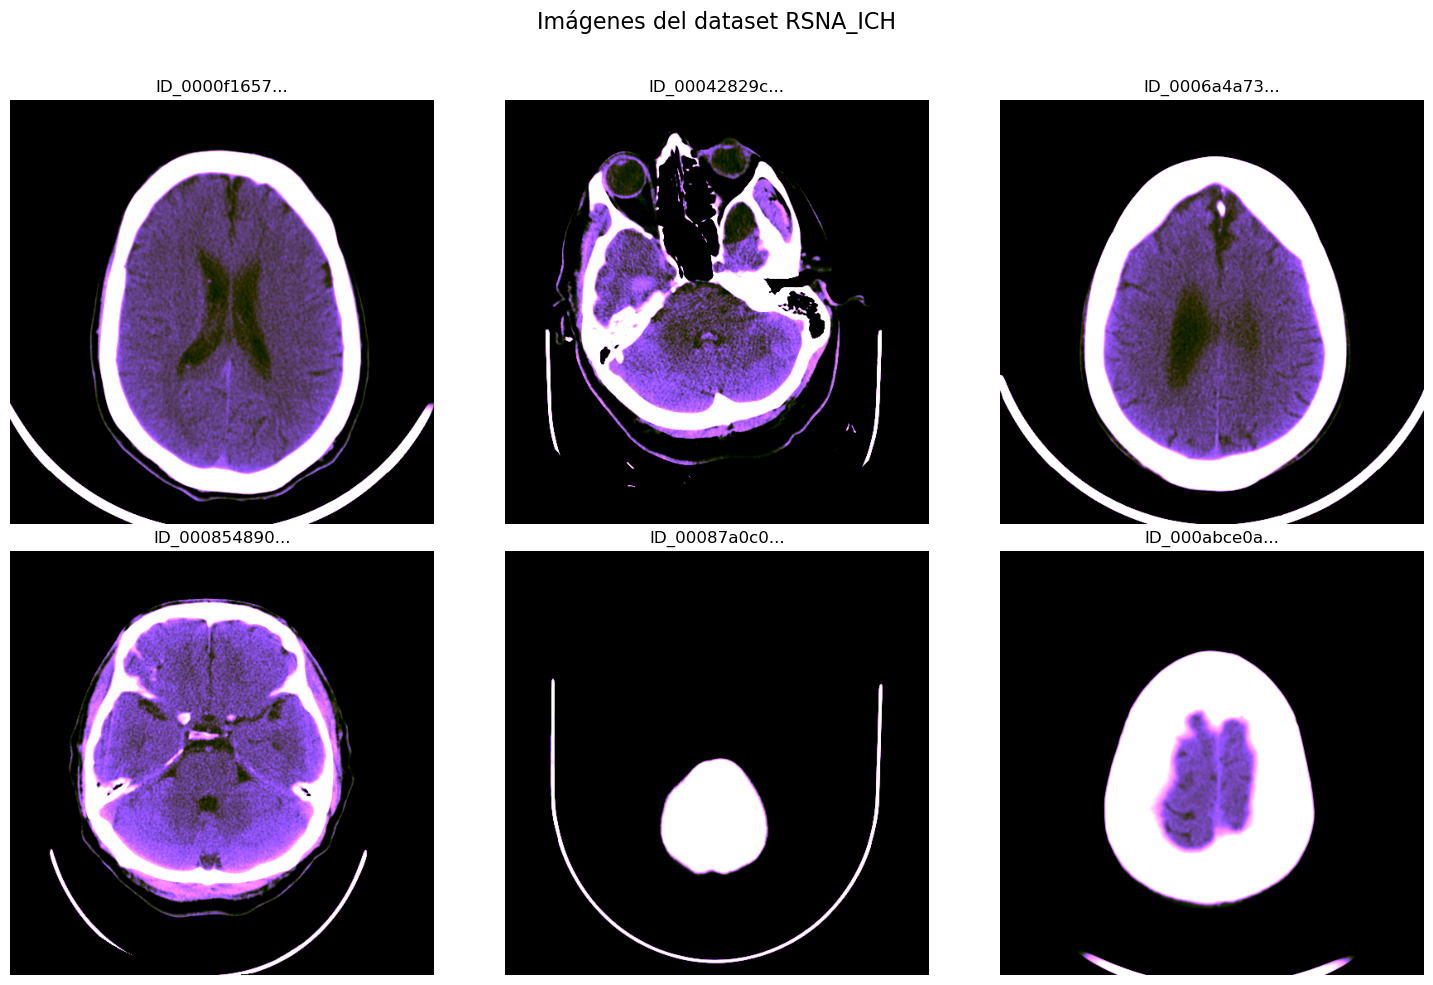

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ruta absoluta al directorio de las imágenes
NPY_DIR = "/data/datasets/RSNA_ICH/original/"

# Listar los primeros 6 archivos .npy del directorio que comiencen por "ID_"
try:
    all_files = os.listdir(NPY_DIR)
except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el directorio en la ruta especificada.")
    print(f"Ruta intentada: {os.path.abspath(NPY_DIR)}")
    all_files = []

npy_files = sorted([f for f in all_files if f.startswith("ID_") and f.endswith(".npy")])[:6]

# Asegurarse de que hay al menos 6 archivos
if len(npy_files) < 6:
    print(f"Advertencia: Se encontraron solo {len(npy_files)} archivos de los 6 solicitados.")
    print("Se mostrarán los que se hayan encontrado.")

if npy_files:
    # Un aspect ratio más cuadrado (ej. 15 de ancho por 10 de alto) funciona mejor
    plt.figure(figsize=(15, 10))

    # Recorrer los archivos y mostrarlos
    for i, filename in enumerate(npy_files):
        img_path = os.path.join(NPY_DIR, filename)
        img_array = np.load(img_path)
        
        # --- CAMBIO 3: CREAR UNA CUADRÍCULA DE 2 FILAS Y 3 COLUMNAS ---
        # plt.subplot(filas, columnas, índice)
        plt.subplot(2, 3, i + 1)
        
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.title(filename[:12] + "...")

    # Título general de la figura
    plt.suptitle("Imágenes del dataset RSNA_ICH", fontsize=16)

    # --- CAMBIO 4: OPTIMIZAR EL ESPACIO EN BLANCO ---
    # tight_layout() ajusta automáticamente los subplots para que no haya solapamientos
    # y se reduzca el espacio en blanco.
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # El rect ajusta el espacio para el suptitle

    # Mostrar la figura
    plt.show()
else:
    print("No se encontraron imágenes para mostrar.")

/tmp/ipykernel_26260/2673644924.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado exitosamente desde: models/rsna/attention/seed0/model.pth
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Bag ID para el índice 10: ID_fe18e73b79

Visualizando la bolsa: ID_fe18e73b79
Predicción (probabilidad de ser positivo): 0.7480
Etiqueta real: 1.0


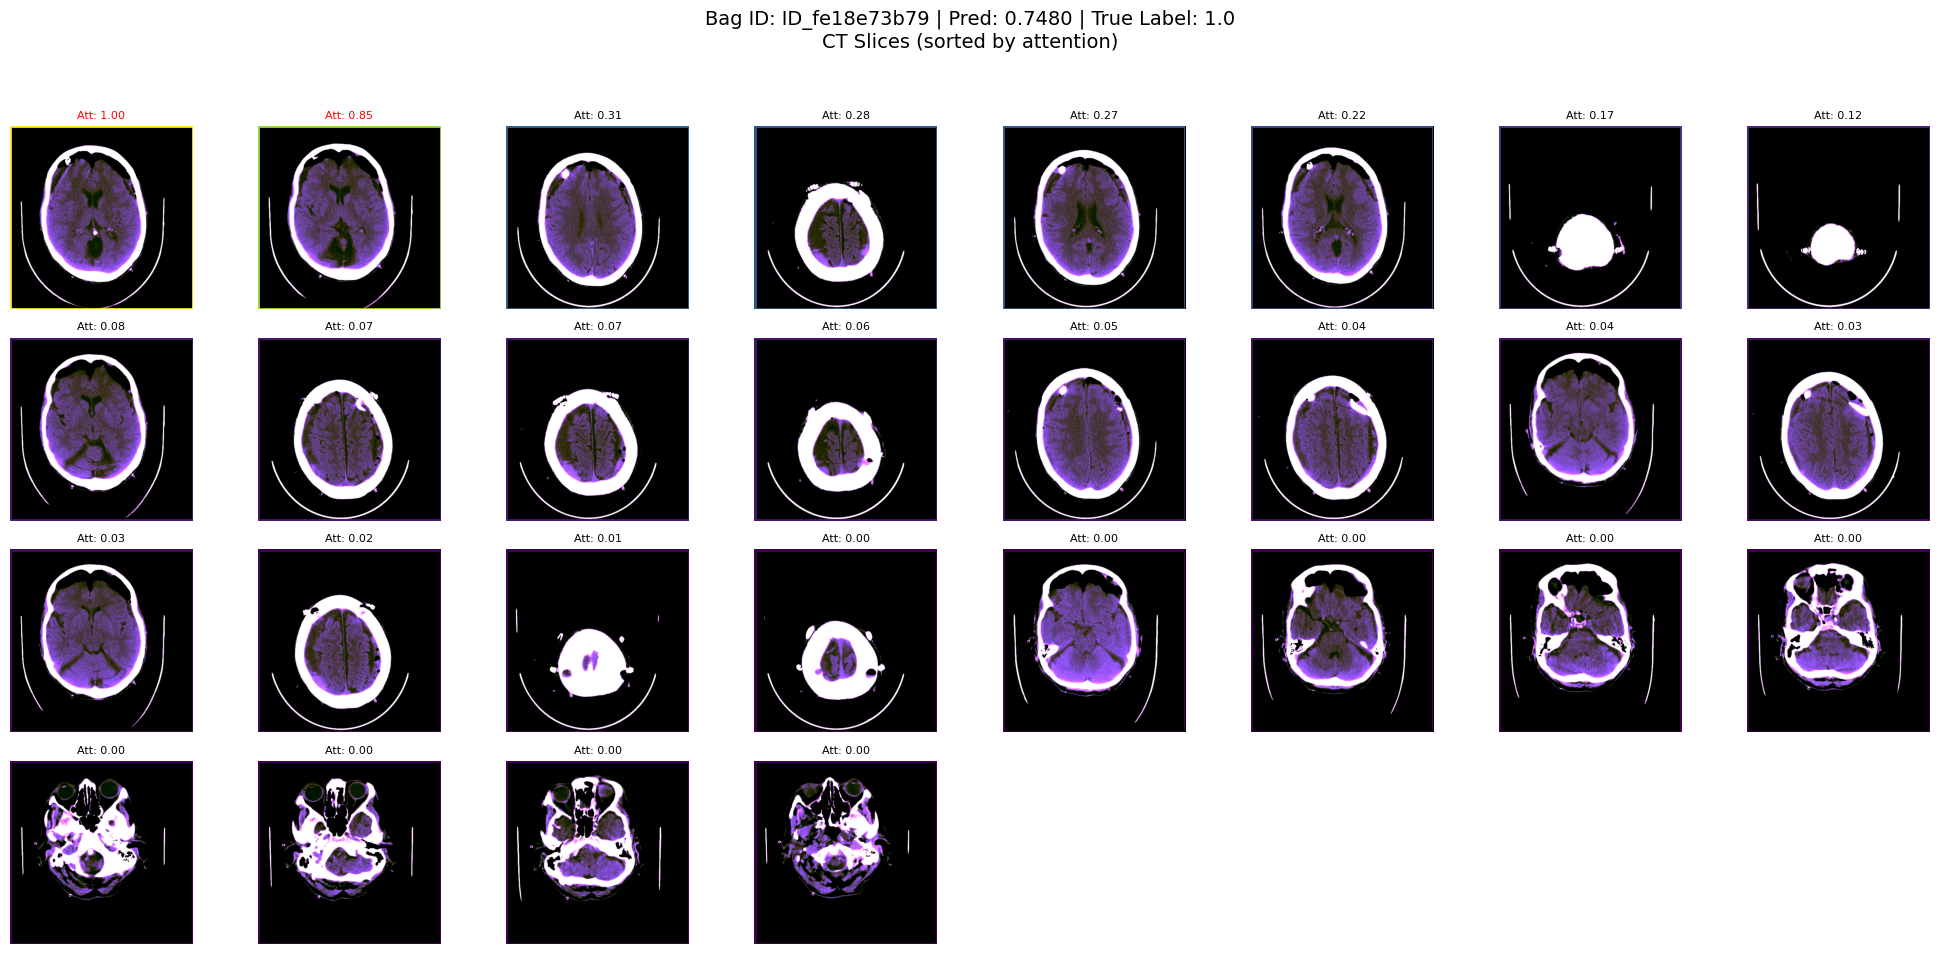

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace # Used to create config object from dictionary

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
# Ajusta esta ruta si tu proyecto no está en /home/javitrucas/TFG
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    # Importa los módulos necesarios de tus scripts
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
    from scripts.model import MILModel
    # Importar normalize si está en plot_utils u otro lugar, o definirla si es simple
    from scripts.plot_utils import normalize # Assuming normalize is a general utility
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    print(f"Current sys.path: {sys.path}")
    sys.exit()

# --- Custom Plotting Function for CT Slices ---
def plot_ct_slices_and_heatmap(patches, attention_scores, bag_id, pred_prob, true_label, num_cols=8):
    """
    Visualiza una serie de parches (slices de CT) con sus pesos de atención.
    
    Args:
        patches (list of np.array): Lista de arrays NumPy, donde cada array es una slice de CT (2D o 3D con canales).
        attention_scores (np.array): Array 1D de pesos de atención, uno por cada parche.
        bag_id (str): ID de la bolsa/paciente para el título.
        pred_prob (float): Probabilidad de predicción del modelo para la bolsa.
        true_label (int/float): Etiqueta real de la bolsa.
        num_cols (int): Número de columnas para organizar el grid de parches.
    """
    if len(patches) != len(attention_scores):
        print("Advertencia: El número de parches y pesos de atención no coincide.")
        # Intentar alinear si es posible, o salir
        min_len = min(len(patches), len(attention_scores))
        patches = patches[:min_len]
        attention_scores = attention_scores[:min_len]
        if min_len == 0:
            print("No hay parches o scores para visualizar.")
            return

    num_patches = len(patches)
    # Limitar el número de parches a mostrar para evitar figuras gigantes
    max_display_patches = num_cols * 10 # Display max 10 rows
    if num_patches > max_display_patches:
        print(f"Mostrando solo los top {max_display_patches} parches con mayor atención.")
        # Seleccionar solo los top N parches para visualización
        top_indices = np.argsort(attention_scores)[::-1][:max_display_patches]
        patches_to_display = [patches[i] for i in top_indices]
        attention_scores_to_display = [attention_scores[i] for i in top_indices]
        num_patches_to_display = len(patches_to_display)
    else:
        patches_to_display = patches
        attention_scores_to_display = attention_scores
        num_patches_to_display = num_patches
    
    num_rows = (num_patches_to_display + num_cols - 1) // num_cols # Calcula el número de filas necesario

    # Ajustar el tamaño de la figura para acomodar más filas
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
    axes = axes.flatten() # Aplanar el array de axes para iterar fácilmente

    # Ordenar los parches a mostrar por sus pesos de atención (de mayor a menor)
    sorted_indices_to_display = np.argsort(attention_scores_to_display)[::-1]
    
    fig.suptitle(f"Bag ID: {bag_id} | Pred: {pred_prob:.4f} | True Label: {true_label}\n"
                 f"CT Slices (sorted by attention)", 
                 fontsize=14)

    for i, idx in enumerate(sorted_indices_to_display):
        if i >= len(axes): # Evitar desbordamiento si hay más parches que subplots
            break
        
        ax = axes[i]
        current_patch = patches_to_display[idx]
        current_attention = attention_scores_to_display[idx]
        
        #imshow puede manejar (H,W) para grayscale y (H,W,3) para RGB
        if current_patch.ndim == 3 and current_patch.shape[-1] == 3:
            ax.imshow(current_patch) # RGB image, no cmap needed
        elif current_patch.ndim == 2:
            ax.imshow(current_patch, cmap='gray') # Grayscale image
        else:
            print(f"Advertencia: El parche en el índice {idx} tiene una forma no soportada para imshow: {current_patch.shape}. Saltando.")
            ax.set_title("Unsupported Img", fontsize=8)
            ax.axis('off')
            continue

        # Configura el título del subplot con el peso de atención
        ax.set_title(f"Att: {current_attention:.2f}", fontsize=8, color='red' if current_attention > 0.5 else 'black')
        ax.axis('off') # Desactivar ejes para una visualización más limpia

        # Opcional: Dibujar un borde para resaltar la atención
        rect = plt.Rectangle((0, 0), current_patch.shape[1]-1, current_patch.shape[0]-1, 
                             linewidth=2, edgecolor=plt.cm.viridis(current_attention), facecolor='none')
        ax.add_patch(rect)

    # Ocultar los ejes no utilizados
    for i in range(num_patches_to_display, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar layout para el supertítulo
    plt.show()

# --- FIN DE LA FUNCIÓN DE PLOTEO CUSTOM ---


# --- PARÁMETROS DE VISUALIZACIÓN ---
# **¡IMPORTANTE!** Ajusta esta ruta al archivo .pth de tu modelo entrenado.
# Por ejemplo, si entrenaste con 'attention' y seed=42, la ruta sería:
# "models/rsna/attention/seed42/model.pth"
# O usa un seed específico que se haya entrenado
MODEL_PATH = "models/rsna/attention/seed0/model.pth" 

# Directorio donde se encuentran las imágenes ORIGINALES en formato .npy
# NO el directorio de features, sino el de las imágenes (slices de CT)
ORIGINAL_DATA_DIR = "/data/datasets/RSNA_ICH/original/"

# Índice de la bolsa del conjunto de test que deseas visualizar.
# Puedes cambiar este número para ver diferentes pacientes/bolsas.
BAG_INDEX_TO_VISUALIZE = 10 

# Configuración del modelo (debe coincidir con la configuración usada durante el entrenamiento)
config_dict = {
    # **** CAMBIO CRÍTICO AQUÍ: 'rsna' en lugar de 'rsna-features_resnet18' ****
    "dataset_name": "rsna", # <--- ESTO DEBE HACER QUE EL DATASET CARGUE IMÁGENES ORIGINALES para VISUALIZACIÓN
    "val_prop": 0.15,
    "seed": 0, # <-- Use the same seed as the model you are loading (e.g., from MODEL_PATH)
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
# Convertimos el diccionario a un objeto Namespace para que se comporte como un objeto con atributos
config = Namespace(**config_dict)

# Dimensiones de las características (deben coincidir con el modelo guardado)
# Nota: Estas son las dimensiones de los features que el MODELO ESPERA (512 para ResNet18)
INPUT_FEATURE_DIM = 512 
FEATURE_DIM = 128

# --- 1. CARGAR MODELO Y DATASET ---
# Configura el dispositivo (GPU si está disponible, de lo contrario CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instancia el modelo MIL
model = MILModel(
    pooling_type='attention', # Asegúrate de que este pooling_type coincide con el modelo que cargas
    input_feature_dim=INPUT_FEATURE_DIM,
    feature_dim=FEATURE_DIM
)

# Carga los pesos del modelo entrenado
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval() # Pone el modelo en modo evaluación (desactiva dropout, batchnorm, etc.)
    print(f"Modelo cargado exitosamente desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo del modelo en la ruta especificada: {MODEL_PATH}")
    print("Por favor, verifica que la ruta sea correcta y que el modelo haya sido entrenado y guardado.")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el estado del modelo: {e}")
    sys.exit()

# --- CARGA DE DATASETS SEPARADOS PARA FEATURES Y IMÁGENES ---
# Este es el paso crucial:
# 1. Cargamos el dataset con la configuración de FEATURES para obtener los inputs para el modelo.
# 2. Cargamos el dataset con la configuración de IMÁGENES ORIGINALES para obtener las imágenes para visualización.

# Dataset para obtener las FEATURES (para el modelo)
config_features = Namespace(**{
    "dataset_name": "rsna-features_resnet18", # Cargar con features
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_features = load_dataset(config=config_features, mode="test")

# Dataset para obtener las RUTAS de las IMÁGENES ORIGINALES (para la visualización)
config_images = Namespace(**{
    "dataset_name": "rsna", # Cargar con imágenes originales
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_images = load_dataset(config=config_images, mode="test")


# Verificar que el índice esté dentro del rango para AMBOS datasets
if BAG_INDEX_TO_VISUALIZE >= len(test_dataset_features) or BAG_INDEX_TO_VISUALIZE >= len(test_dataset_images):
    print(f"Error: BAG_INDEX_TO_VISUALIZE ({BAG_INDEX_TO_VISUALIZE}) está fuera de rango para uno de los datasets.")
    sys.exit()

# Obtener la muestra de FEATURES para el modelo
sample_features = test_dataset_features[BAG_INDEX_TO_VISUALIZE]
bag_features_for_model = sample_features[0] # El primer elemento es el tensor de features
bag_label = sample_features[1] # La etiqueta de la bolsa es la misma para ambos


# --- Recuperar el bag_id y las rutas de las instancias (de las imágenes) ---
# Usamos el dataset de IMÁGENES para obtener el bag_id y las rutas de las instancias de imagen
try:
    bag_id = test_dataset_images.bag_names[BAG_INDEX_TO_VISUALIZE]
    print(f"Bag ID para el índice {BAG_INDEX_TO_VISUALIZE}: {bag_id}")
except AttributeError:
    print("Error: El atributo 'bag_names' no se encontró en el dataset de IMÁGENES. Revisa `RSNADataset.py`.")
    sys.exit()
except IndexError:
    print(f"Error: El índice {BAG_INDEX_TO_VISUALIZE} está fuera de rango para `test_dataset_images.bag_names`.")
    sys.exit()

# Las rutas de las instancias (de las imágenes) se encuentran en data_dict del dataset de IMÁGENES
instance_paths_for_images = []
try:
    if hasattr(test_dataset_images, 'data_dict') and bag_id in test_dataset_images.data_dict:
        instance_paths_for_images = test_dataset_images.data_dict[bag_id]['inst_paths']
    else:
        raise AttributeError("El dataset de IMÁGENES no tiene el atributo 'data_dict' o el 'bag_id' no es una clave válida.")
except (AttributeError, KeyError) as e:
    print(f"Error al obtener las rutas de las IMÁGENES para el bag_id '{bag_id}': {e}")
    print("Asegúrate de que RSNADataset.py inicializa 'data_dict' y lo usa correctamente para 'inst_paths' cuando carga imágenes.")
    sys.exit()


# --- 2. OBTENER PESOS DE ATENCIÓN (USANDO FEATURES) ---
with torch.no_grad():
    bag_tensor = bag_features_for_model.unsqueeze(0).to(device) 
    
    prediction, attention_weights = model(bag_tensor)
    
    attention_weights = attention_weights.squeeze(0).cpu().numpy()
    prediction_prob = torch.sigmoid(prediction).item()

# --- 3. CARGAR IMÁGENES ORIGINALES DE LOS PARCHES (PARA VISUALIZACIÓN) ---
patches_image_data = [] 
if instance_paths_for_images: 
    for p_path in instance_paths_for_images:
        full_path = p_path # p_path ya debería ser la ruta completa a la imagen .npy
        
        if os.path.exists(full_path):
            try:
                img_data = np.load(full_path)
                
                # Aceptar imágenes 2D (grayscale) o 3D con 3 canales (RGB)
                if img_data.ndim == 2 or (img_data.ndim == 3 and img_data.shape[-1] == 3):
                    patches_image_data.append(img_data)
                elif img_data.ndim == 3 and img_data.shape[-1] == 1: # Handle (H,W,1) as grayscale
                    patches_image_data.append(img_data.squeeze(axis=-1))
                else:
                    print(f"Advertencia: El archivo {full_path} no es una imagen 2D o RGB (H,W,3). Shape: {img_data.shape}. Saltando.")

            except Exception as e:
                print(f"Advertencia: Error al cargar o procesar el archivo {full_path}: {e}")
        else:
            print(f"Advertencia: No se encontró el parche de imagen en la ruta: {full_path}")

if not patches_image_data:
    print("Error: No se pudieron cargar parches de IMAGEN para la visualización. Verifica las rutas y los archivos .npy.")
    sys.exit()
else:
    # --- 4. VISUALIZACIÓN ---
    print(f"\nVisualizando la bolsa: {bag_id}")
    print(f"Predicción (probabilidad de ser positivo): {prediction_prob:.4f}")
    print(f"Etiqueta real: {bag_label.item()}") 

    normalized_attention = normalize(attention_weights)
    
    # Llama a la nueva función de ploteo para CT Slices
    plot_ct_slices_and_heatmap(
        patches=patches_image_data, # Pasa las imágenes reales
        attention_scores=normalized_attention,
        bag_id=bag_id,
        pred_prob=prediction_prob,
        true_label=bag_label.item()
    )